In [11]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                                    MulticlassClassificationEvaluator)
from pyspark.ml.feature import (StringIndexer, VectorAssembler,
                               OneHotEncoder)
from pyspark.sql.session import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, sum
from pyspark.ml.classification import (RandomForestClassifier,
                                       GBTClassifier,
                                       DecisionTreeClassifier)
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StandardScaler


In [2]:
spark = SparkSession.builder.config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.42.0.0').getOrCreate()
df_spark = spark.read.format('jdbc').options(driver='org.sqlite.JDBC', \
                                             inferSchema = True,\
                                             header = True,\
                                             dbtable = 'fires',\
                                             url= 'jdbc:sqlite:/D:/0_Machine_Learning/0.my_code_excercise/0.My_Portfolio/27.mygis/FPA_FOD_20170508.sqlite').load()



In [7]:
def data_reader(df_spark):
    
    selected_col = ['FIRE_SIZE', 'FIRE_SIZE_CLASS',\
               'STATE','FIRE_YEAR', 'DISCOVERY_DOY', \
                'STAT_CAUSE_CODE','DISCOVERY_TIME', 'CONT_TIME'] # 'CONT_DOY', # 'LONGITUDE', 'LATITUDE',
    
    df = df_spark.select(selected_col)
    
    df = df.withColumn("FIRE_SIZE", df.FIRE_SIZE.cast("double"))
    df = df.withColumn("FIRE_YEAR", df.FIRE_YEAR.cast("integer"))
    df = df.withColumn("DISCOVERY_DOY", df.DISCOVERY_DOY.cast("integer"))
    #df = df.withColumn("CONT_DOY", df.CONT_DOY.cast("integer"))
    df = df.withColumn("STAT_CAUSE_CODE", df.STAT_CAUSE_CODE.cast("integer"))

    return df

In [10]:
my_df = data_reader(df_spark)
my_df.show(n=4)

+---------+---------------+-----+---------+-------------+---------------+--------------+---------+
|FIRE_SIZE|FIRE_SIZE_CLASS|STATE|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|DISCOVERY_TIME|CONT_TIME|
+---------+---------------+-----+---------+-------------+---------------+--------------+---------+
|      0.1|              A|   CA|     2005|           33|              9|          1300|     1730|
|     0.25|              A|   CA|     2004|          133|              1|          0845|     1530|
|      0.1|              A|   CA|     2004|          152|              5|          1921|     2024|
|      0.1|              A|   CA|     2004|          180|              1|          1600|     1400|
+---------+---------------+-----+---------+-------------+---------------+--------------+---------+
only showing top 4 rows



In [34]:
desired_cols = ['FIRE_SIZE_CLASS', 'STATE', 'FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE']

df_final = my_df.select(desired_cols)


indexer = StringIndexer(inputCol='FIRE_SIZE_CLASS', outputCol='FIRE_SIZE_CLASS_index')

indexed_df = indexer.fit(df_final).transform(df_final)

STATE_indexer = StringIndexer(inputCol='STATE', outputCol='STATE_Index')

my_df_final = STATE_indexer.fit(indexed_df).transform(indexed_df)

inputCols = ['STATE_Index', 'FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE']

my_df_final = my_df_final.select('FIRE_YEAR','DISCOVERY_DOY','STAT_CAUSE_CODE','FIRE_SIZE_CLASS_index','STATE_Index')
#assembler = VectorAssembler(inputCols=inputCols, outputCol='raw_features')

#scaler = StandardScaler(inputCol='raw_features', outputCol='features', withMean=True, withStd=True)



In [35]:
my_df_final.show()

+---------+-------------+---------------+---------------------+-----------+
|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|FIRE_SIZE_CLASS_index|STATE_Index|
+---------+-------------+---------------+---------------------+-----------+
|     2005|           33|              9|                  1.0|        0.0|
|     2004|          133|              1|                  1.0|        0.0|
|     2004|          152|              5|                  1.0|        0.0|
|     2004|          180|              1|                  1.0|        0.0|
|     2004|          180|              1|                  1.0|        0.0|
|     2004|          182|              1|                  1.0|        0.0|
|     2004|          183|              1|                  1.0|        0.0|
|     2005|           67|              5|                  0.0|        0.0|
|     2005|           74|              5|                  0.0|        0.0|
|     2004|          183|              1|                  1.0|        0.0|
|     2004| 

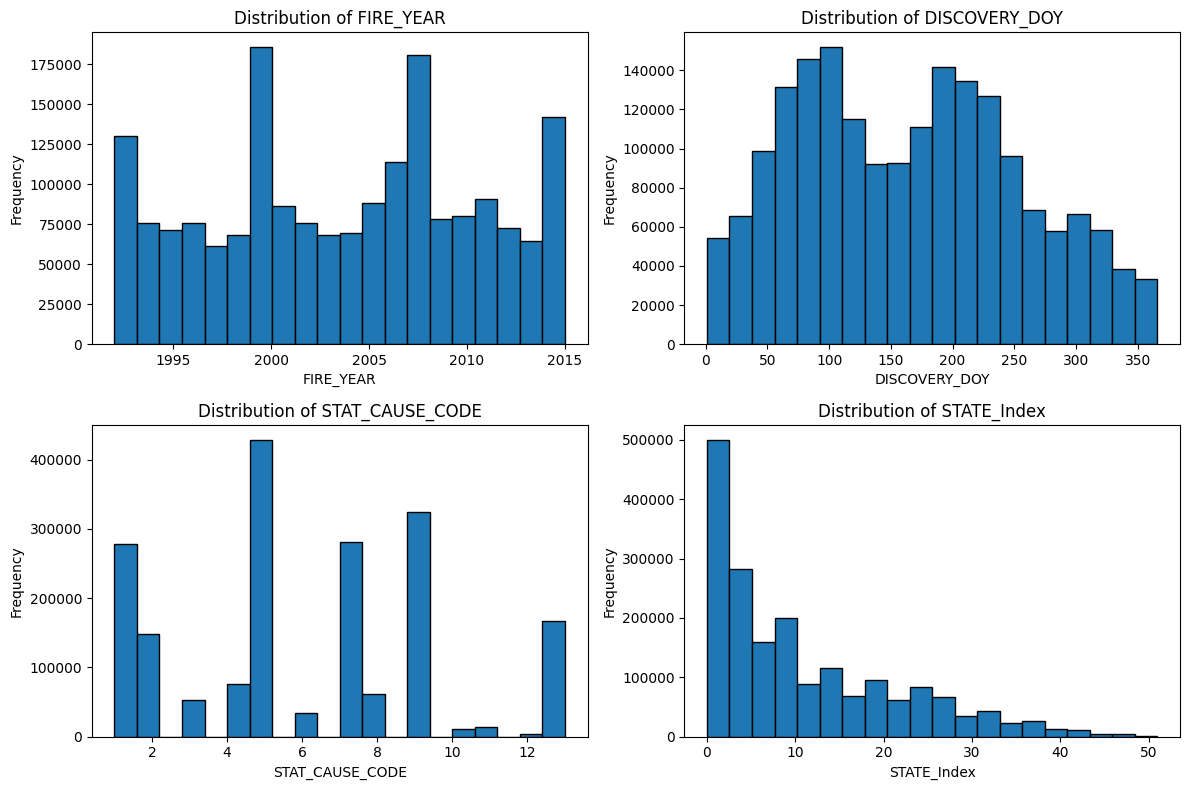

In [37]:
import matplotlib.pyplot as plt
df=my_df_final.toPandas()
# Select the features for plotting
features_to_plot = ['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STATE_Index']

# Create subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot histograms for each feature
for ax, feature in zip(axes.flatten(), features_to_plot):
    ax.hist(df[feature], bins=20, edgecolor='black')
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [38]:
features = my_df_final.drop('FIRE_SIZE_CLASS_index')
label = my_df_final.select('FIRE_SIZE_CLASS_index')

In [41]:
features.show()

+---------+-------------+---------------+-----------+
|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|STATE_Index|
+---------+-------------+---------------+-----------+
|     2005|           33|              9|        0.0|
|     2004|          133|              1|        0.0|
|     2004|          152|              5|        0.0|
|     2004|          180|              1|        0.0|
|     2004|          180|              1|        0.0|
|     2004|          182|              1|        0.0|
|     2004|          183|              1|        0.0|
|     2005|           67|              5|        0.0|
|     2005|           74|              5|        0.0|
|     2004|          183|              1|        0.0|
|     2004|          184|              1|        0.0|
|     2004|          184|              1|        0.0|
|     2004|          247|              9|        0.0|
|     2004|          272|              4|        0.0|
|     2004|          277|              1|        0.0|
|     2004|          277|   

In [80]:

# Create a list of input column names
inputCols = features.columns

# Assemble the input columns into a vector column
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")
assembled_df = assembler.transform(my_df_final)

# Apply feature scaling using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

# Select the scaled features
scaled_features_df = scaled_df.select("scaled_features")



In [79]:
scaled_df.head(4)

[Row(FIRE_YEAR=2005, DISCOVERY_DOY=33, STAT_CAUSE_CODE=9, STATE_Index=0.0, features=DenseVector([2005.0, 33.0, 9.0, 0.0]), scaled_features=DenseVector([0.1936, -1.4629, 0.8671, -1.0326])),
 Row(FIRE_YEAR=2004, DISCOVERY_DOY=133, STAT_CAUSE_CODE=1, STATE_Index=0.0, features=DenseVector([2004.0, 133.0, 1.0, 0.0]), scaled_features=DenseVector([0.0435, -0.3523, -1.4292, -1.0326])),
 Row(FIRE_YEAR=2004, DISCOVERY_DOY=152, STAT_CAUSE_CODE=5, STATE_Index=0.0, features=DenseVector([2004.0, 152.0, 5.0, 0.0]), scaled_features=DenseVector([0.0435, -0.1413, -0.281, -1.0326])),
 Row(FIRE_YEAR=2004, DISCOVERY_DOY=180, STAT_CAUSE_CODE=1, STATE_Index=0.0, features=DenseVector([2004.0, 180.0, 1.0, 0.0]), scaled_features=DenseVector([0.0435, 0.1697, -1.4292, -1.0326]))]

In [81]:
scaled_df.head(4)

[Row(FIRE_YEAR=2005, DISCOVERY_DOY=33, STAT_CAUSE_CODE=9, FIRE_SIZE_CLASS_index=1.0, STATE_Index=0.0, features=DenseVector([2005.0, 33.0, 9.0, 0.0]), scaled_features=DenseVector([0.1936, -1.4629, 0.8671, -1.0326])),
 Row(FIRE_YEAR=2004, DISCOVERY_DOY=133, STAT_CAUSE_CODE=1, FIRE_SIZE_CLASS_index=1.0, STATE_Index=0.0, features=DenseVector([2004.0, 133.0, 1.0, 0.0]), scaled_features=DenseVector([0.0435, -0.3523, -1.4292, -1.0326])),
 Row(FIRE_YEAR=2004, DISCOVERY_DOY=152, STAT_CAUSE_CODE=5, FIRE_SIZE_CLASS_index=1.0, STATE_Index=0.0, features=DenseVector([2004.0, 152.0, 5.0, 0.0]), scaled_features=DenseVector([0.0435, -0.1413, -0.281, -1.0326])),
 Row(FIRE_YEAR=2004, DISCOVERY_DOY=180, STAT_CAUSE_CODE=1, FIRE_SIZE_CLASS_index=1.0, STATE_Index=0.0, features=DenseVector([2004.0, 180.0, 1.0, 0.0]), scaled_features=DenseVector([0.0435, 0.1697, -1.4292, -1.0326]))]

In [82]:
data = scaled_df.select('scaled_features', 'FIRE_SIZE_CLASS_index')

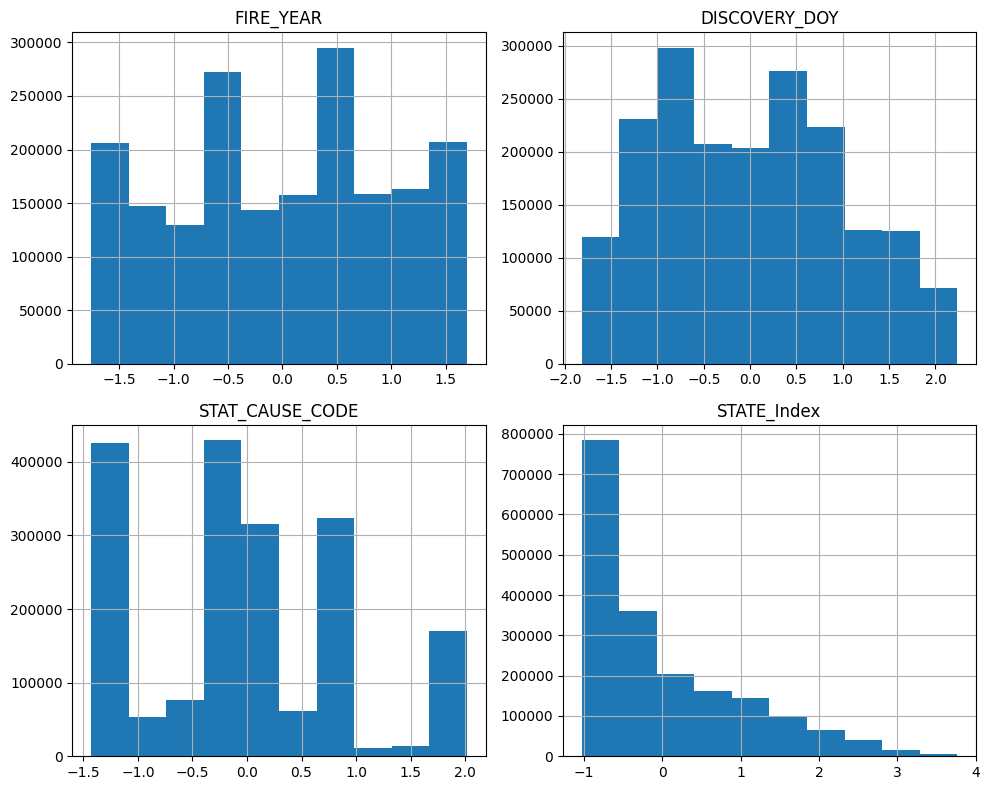

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the scaled_features column to a pandas DataFrame
scaled_features_pd = scaled_features_df.toPandas()

# Iterate over each row and extract the features
features_list = []
for row in scaled_features_pd['scaled_features']:
    features_list.append(row.toArray())

# Create a DataFrame with the features
features_df = pd.DataFrame(features_list, columns=inputCols)

# Plot histograms for each feature
features_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()


In [73]:
features_list

[array([ 0.19360746, -1.4629136 ,  0.86713092, -1.03260826]),
 array([ 0.04352714, -0.35228264, -1.42917247, -1.03260826]),
 array([ 0.04352714, -0.14126276, -0.28102078, -1.03260826]),
 array([ 0.04352714,  0.16971391, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.16971391, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.19192653, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.20303284, -1.42917247, -1.03260826]),
 array([ 0.19360746, -1.08529908, -0.28102078, -1.03260826]),
 array([ 0.19360746, -1.00755491, -0.28102078, -1.03260826]),
 array([ 0.04352714,  0.20303284, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.21413914, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.21413914, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.91383665,  0.86713092, -1.03260826]),
 array([ 0.04352714,  1.19149439, -0.5680587 , -1.03260826]),
 array([ 0.04352714,  1.24702594, -1.42917247, -1.03260826]),
 array([ 0.04352714,  1.24702594, -1.42917247, -1.03260826]),
 array([

In [74]:
features.show()

+---------+-------------+---------------+-----------+
|FIRE_YEAR|DISCOVERY_DOY|STAT_CAUSE_CODE|STATE_Index|
+---------+-------------+---------------+-----------+
|     2005|           33|              9|        0.0|
|     2004|          133|              1|        0.0|
|     2004|          152|              5|        0.0|
|     2004|          180|              1|        0.0|
|     2004|          180|              1|        0.0|
|     2004|          182|              1|        0.0|
|     2004|          183|              1|        0.0|
|     2005|           67|              5|        0.0|
|     2005|           74|              5|        0.0|
|     2004|          183|              1|        0.0|
|     2004|          184|              1|        0.0|
|     2004|          184|              1|        0.0|
|     2004|          247|              9|        0.0|
|     2004|          272|              4|        0.0|
|     2004|          277|              1|        0.0|
|     2004|          277|   

In [83]:
data.show()

+--------------------+---------------------+
|     scaled_features|FIRE_SIZE_CLASS_index|
+--------------------+---------------------+
|[0.19360746160853...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.19360746160853...|                  0.0|
|[0.19360746160853...|                  0.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  0.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  1.0|
|[0.04352713699106...|                  6.0|
|[0.04352713699106...|                  6.0|
|[0.04352713699106...|                  1.0|
|[0.043527

In [84]:
log_reg_model = LogisticRegression(featuresCol='scaled_features', labelCol='FIRE_SIZE_CLASS_index', family="multinomial")

train_data, test_data = data.randomSplit([0.7, 0.3])

fit_model = log_reg_model.fit(train_data)

predictions = fit_model.transform(test_data)

outputCol = 'FIRE_SIZE_CLASS_index'
#evaluator = MulticlassClassificationEvaluator(labelCol="FIRE_SIZE_CLASS_Index", metricName="accuracy")
evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="f1")
f_1_score = evaluator.evaluate(predictions)

evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="weightedPrecision")
weighted_Precision = evaluator.evaluate(predictions)

evaluator = MulticlassClassificationEvaluator(labelCol=outputCol, metricName="weightedRecall")
weighted_Recall = evaluator.evaluate(predictions)

# Compute confusion matrix
predictionAndLabels = predictions.select("prediction", outputCol)
confusionMatrix = predictionAndLabels.groupBy(outputCol, "prediction").count()

# Collect the confusion matrix into a Pandas DataFrame
confusionMatrix = confusionMatrix.toPandas()

# Pivot the confusion matrix
confusionMatrix = confusionMatrix.pivot(index=outputCol, columns="prediction", values="count").fillna(0)

In [86]:
print (f"Acuuracy = {accuracy}\n"
       f"f1_score = {f_1_score}, \n"
       f"weighted_Precision = {weighted_Precision}, \n"
       f"weighted_Recall = {weighted_Recall}, \n"
       f"confusionMatrix: \n"
       f"{confusionMatrix}, \n")
#       f"classification_metrics: \n"
#        f"{classification_metrics}")

Acuuracy = 0.5045560747663551
f1_score = 0.4304224595842838, 
weighted_Precision = 0.4159376694496627, 
weighted_Recall = 0.5045560747663551, 
confusionMatrix: 
prediction                0.0    1.0
FIRE_SIZE_CLASS_index               
0.0                    237340  44665
1.0                    152768  47714
2.0                     55197  11037
3.0                      6565   1917
4.0                      2993   1254
5.0                      1429    953
6.0                       559    569, 



In [87]:
train_data.show()

+--------------------+---------------------+
|     scaled_features|FIRE_SIZE_CLASS_index|
+--------------------+---------------------+
|[-1.7574367584186...|                  1.0|
|[-1.7574367584186...|                  1.0|
|[-1.7574367584186...|                  1.0|
|[-1.7574367584186...|                  2.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  1.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  2.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.7574367584186...|                  0.0|
|[-1.75743

In [93]:
features_list

[array([ 0.19360746, -1.4629136 ,  0.86713092, -1.03260826]),
 array([ 0.04352714, -0.35228264, -1.42917247, -1.03260826]),
 array([ 0.04352714, -0.14126276, -0.28102078, -1.03260826]),
 array([ 0.04352714,  0.16971391, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.16971391, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.19192653, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.20303284, -1.42917247, -1.03260826]),
 array([ 0.19360746, -1.08529908, -0.28102078, -1.03260826]),
 array([ 0.19360746, -1.00755491, -0.28102078, -1.03260826]),
 array([ 0.04352714,  0.20303284, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.21413914, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.21413914, -1.42917247, -1.03260826]),
 array([ 0.04352714,  0.91383665,  0.86713092, -1.03260826]),
 array([ 0.04352714,  1.19149439, -0.5680587 , -1.03260826]),
 array([ 0.04352714,  1.24702594, -1.42917247, -1.03260826]),
 array([ 0.04352714,  1.24702594, -1.42917247, -1.03260826]),
 array([